In [1]:
# Set up for the project
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras import backend as K
from keras import regularizers

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imresize

Using TensorFlow backend.


In [2]:
# Get the original dimension of dataset
(X_train_orig, Y_train), (X_test_orig, Y_test) = mnist.load_data()
print("Training data shape: ", X_train_orig.shape)
print("Training labels shape: ", Y_train.shape)
print("Testing data shape: ", X_test_orig.shape)
print("Test labels shape: ", Y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Testing data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [3]:
# Cut the traning and testing set by 1/10 to reduce operation time
num_train = 60000
mask_train = range(num_train)
X_train_orig = X_train_orig[mask_train]
Y_train = Y_train[mask_train]

num_test = 10000
mask_test = range(num_test)
X_test_orig = X_test_orig[mask_test]
Y_test = Y_test[mask_test]

print("Training data shape: ", X_train_orig.shape)
print("Training labels shape: ", Y_train.shape)
print("Testing data shape: ", X_test_orig.shape)
print("Test labels shape: ", Y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Testing data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


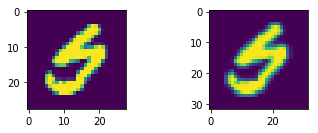

The original shape is:  (28, 28)
The new image shape is:  (32, 32)


In [4]:
# Resize the images to 32*32 as required
# But why resize it: Because if we follow the vgg network, the dimension decreases dramatically to 1x1 at last
# Visualize and verify the functionality of imresize
a = random.randint(0,num_train)
plt.subplot(221)
plt.imshow(X_train_orig[a])
newimg = imresize(X_train_orig[a],(32,32))
plt.subplot(222)
plt.imshow(newimg)
plt.show()
print("The original shape is: ", X_train_orig[a].shape)
print("The new image shape is: ", newimg.shape)

The four randomly-chosen numbers are: 9980 33684 5865 4917
The size of the 4 randomly-chosen images are:  (32, 32) (32, 32) (32, 32) (32, 32)
The corresponding labels for the 4 images are: 4 1 9 3


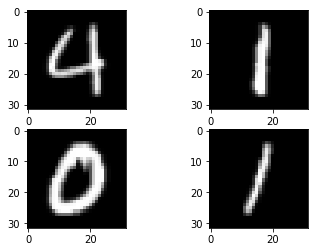

In [5]:
# Resize all images in training and test sets
X_train = np.zeros((num_train,32,32))
X_test = np.zeros((num_test,32,32))

for i in range(num_train):
    X_train[i] = imresize(X_train_orig[i],(32,32))

for j in range(num_test):
    X_test[j] = imresize(X_test_orig[j],(32,32))

# Test with some random images
a = random.randint(0,num_train)
b = random.randint(0,num_train)
c = random.randint(0,num_test)
d = random.randint(0,num_test)
plt.subplot(221)
plt.imshow(X_train[a], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[b], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_test[c], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_test[d], cmap=plt.get_cmap('gray'))

print("The four randomly-chosen numbers are:", a,b,c,d)
print("The size of the 4 randomly-chosen images are: ",X_train[a].shape, X_train[b].shape, 
                                                     X_test[c].shape, X_test[d].shape)
print("The corresponding labels for the 4 images are:", Y_train[a], Y_train[b], Y_train[c], Y_train[d])

In [6]:
# Preprocessing: reshape the image data into rows
img_rows = 32
img_cols = 32
num_classes = 10
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Preprocessing: subtract the mean image
train_mean = np.mean(X_train,axis=0)
test_mean = np.mean(X_test,axis=0)
X_train -= train_mean
X_test -= test_mean

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train,num_classes)
Y_test = keras.utils.to_categorical(Y_test,num_classes)

print("Training data shape: ", X_train.shape)
print("Training labels shape: ", Y_train.shape)
print("Testing data shape: ", X_test.shape)
print("Test labels shape: ", Y_test.shape)
print("Input shape: ", input_shape)

Training data shape:  (60000, 32, 32, 1)
Training labels shape:  (60000, 10)
Testing data shape:  (10000, 32, 32, 1)
Test labels shape:  (10000, 10)
Input shape:  (32, 32, 1)


In [7]:
# Modify the hyperparameters here
batch_size = 512
epochs = 10

In [8]:
def simple_conv_net():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))

    model.add(Activation('softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
simple_conv = simple_conv_net()
simple_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
__________

In [10]:
simpleConv_history = simple_conv.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=epochs,batch_size=batch_size)
simpleConv_scores = simple_conv.evaluate(X_test,Y_test,verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 455s - loss: 0.1246 - acc: 0.9614 - val_loss: 0.1027 - val_acc: 0.9672
Epoch 2/10
60000/60000 [==============================] - 462s - loss: 0.0298 - acc: 0.9914 - val_loss: 0.0355 - val_acc: 0.9886
Epoch 3/10
60000/60000 [==============================] - 456s - loss: 0.0193 - acc: 0.9941 - val_loss: 0.0374 - val_acc: 0.9877
Epoch 4/10
60000/60000 [==============================] - 453s - loss: 0.0116 - acc: 0.9969 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 5/10
60000/60000 [==============================] - 486s - loss: 0.0083 - acc: 0.9978 - val_loss: 0.0297 - val_acc: 0.9905
Epoch 6/10
60000/60000 [==============================] - 496s - loss: 0.0052 - acc: 0.9989 - val_loss: 0.0218 - val_acc: 0.9936
Epoch 7/10
60000/60000 [==============================] - 509s - loss: 0.0042 - acc: 0.9990 - val_loss: 0.0213 - val_acc: 0.9930
Epoch 8/10
60000/60000 [=======================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


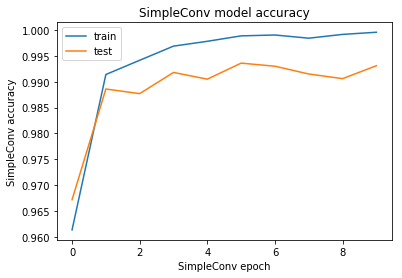

In [11]:
# Simple_conv: list all data in history
print(simpleConv_history.history.keys())

# Simple_conv: summarize history for accuracy
plt.plot(simpleConv_history.history['acc'])
plt.plot(simpleConv_history.history['val_acc'])
plt.title('SimpleConv model accuracy')
plt.ylabel('SimpleConv accuracy')
plt.xlabel('SimpleConv epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

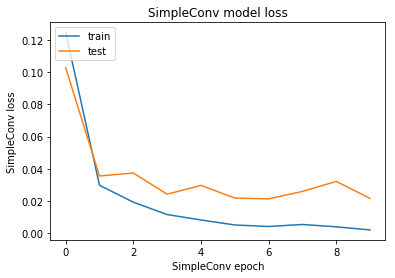

In [12]:
# Simple_conv: summarize history for loss
plt.plot(simpleConv_history.history['loss'])
plt.plot(simpleConv_history.history['val_loss'])
plt.title('SimpleConv model loss')
plt.ylabel('SimpleConv loss')
plt.xlabel('SimpleConv epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Define the VGG-11 model, VGG paper model A
# Use same padding since the input shape(32,32,3) for this project is significantly smaller than that in the paper(224,224,3)
def VGG_model():
    model = Sequential()
    regu = 5e-4
    model.add(Conv2D(64,(3,3), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regu)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regu)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Compile model
#     learning_rate = 0.01
#     decay = learning_rate/epochs
#     adam_customized = keras.optimizers.Adam(lr=learning_rate,decay=decay)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [14]:
# Build the vgg model
vgg11_model = VGG_model()
vgg11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 128)       0         
__________

In [ ]:
# Fit the vgg model
vgg_history = vgg11_model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=epochs,batch_size=batch_size)
vgg_scores = vgg11_model.evaluate(X_test,Y_test,verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7272s - loss: 2.5981 - acc: 0.9168 - val_loss: 7.6747 - val_acc: 0.4146
Epoch 2/10
60000/60000 [==============================] - 5404s - loss: 1.1512 - acc: 0.9856 - val_loss: 0.7982 - val_acc: 0.9704
Epoch 3/10
60000/60000 [==============================] - 5543s - loss: 0.5282 - acc: 0.9874 - val_loss: 0.3981 - val_acc: 0.9789
Epoch 4/10
60000/60000 [==============================] - 5489s - loss: 0.2857 - acc: 0.9895 - val_loss: 0.3397 - val_acc: 0.9530
Epoch 5/10
60000/60000 [==============================] - 5477s - loss: 0.1780 - acc: 0.9914 - val_loss: 0.2028 - val_acc: 0.9800
Epoch 6/10
60000/60000 [==============================] - 5108s - loss: 0.1333 - acc: 0.9917 - val_loss: 0.1604 - val_acc: 0.9809
Epoch 7/10
50688/60000 [========================>.....] - ETA: 622s - loss: 0.1043 - acc: 0.9930

In [ ]:
# VGG: list all data in history
print(vgg_history.history.keys())

# VGG: summarize history for accuracy
plt.plot(vgg_history.history['acc'])
plt.plot(vgg_history.history['val_acc'])
plt.title('vgg model accuracy')
plt.ylabel('vgg accuracy')
plt.xlabel('vgg epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# VGG: summarize history for loss
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG model loss')
plt.ylabel('VGG loss')
plt.xlabel('VGG epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save the model
import os
project_dir = os.getcwd()
model_dir = project_dir + "/models/"
vgg_model_loc = model_dir + "vgg11.h5"
vgg_json_loc = model_dir + "vgg11.json"

from keras.models import model_from_json

# serialize model to JSON
vgg11_model_json = vgg11_model.to_json()
with open(vgg_json_loc,"w") as json_file:
    json_file.write(vgg11_model_json)

# serialize weights to HDF5
vgg11_model.save_weights(vgg_model_loc)
print("Saved model to disk")


In [ ]:
# load json and create model
json_file = open(vgg_json_loc,"r")
loaded_vgg_json = json_file.read()
json_file.close()
loaded_vgg11 = model_from_json(loaded_vgg_json)
# load weights into new model
loaded_vgg11.load_weights(vgg_model_loc)
print("Model Loaded")

In [ ]:
loaded_vgg11.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
scores = loaded_vgg11.evaluate(X_test,Y_test,verbose=0)

In [ ]:
print("%s: %.2f%%" % (loaded_vgg11.metrics_names[1], scores[1]*100))